In [2]:
import pathlib

# RDKit imports:
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    rdCoordGen,
)
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True  # Use higher quality images for molecules

# For visualization of molecules and orbitals:
import py3Dmol
import fortecubeview

# pyscf imports:
from pyscf import gto, scf, lo, tools

# For plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="ticks", context="talk", palette="muted")

# For numerics:
import numpy as np
import pandas as pd

pd.options.display.float_format = "{:,.3f}".format

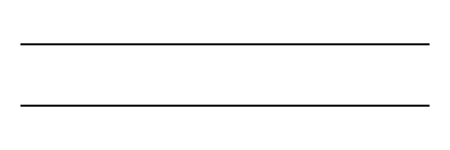

In [3]:
molecule_name = "ethene"
molecule = Chem.MolFromSmiles("C=C")  # Generate the molecule from smiles
molecule

In [4]:
def get_xyz(molecule, optimize=False):
    """Get xyz-coordinates for the molecule"""
    mol = Chem.Mol(molecule)
    mol = AllChem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    if optimize:  # Optimize the molecules with the MM force field:
        AllChem.MMFFOptimizeMolecule(mol)
    xyz = []
    for lines in Chem.MolToXYZBlock(mol).split("\n")[2:]:
        strip = lines.strip()
        if strip:
            xyz.append(strip)
    xyz = "\n".join(xyz)
    return mol, xyz

In [5]:
molecule3d, xyz = get_xyz(molecule)

In [6]:
view = py3Dmol.view(
    data=Chem.MolToMolBlock(molecule3d),
    style={"stick": {}, "sphere": {"scale": 0.3}},
    width=300,
    height=300,
)
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
def run_calculation(xyz, basis="sto-3g"):
    """Calculate the energy (+ additional things like MO coefficients) with pyscf."""
    mol = gto.M(
        atom=xyz,
        basis=basis,
        unit="ANG",
        symmetry=True,
    )
    mol.build()
    mf = scf.RHF(mol).run()
    return mf, mol

In [8]:
mf, mol = run_calculation(xyz, basis="sto-3g")

converged SCF energy = -77.069961819782


In [9]:
table = pd.DataFrame({"Energy": mf.mo_energy, "Occupancy": mf.mo_occ})
table

,Energy,Occupancy
0,-11.017,2.000
1,-11.016,2.000
2,-0.986,2.000
3,-0.735,2.000
4,-0.616,2.000
5,-0.519,2.000
6,-0.466,2.000
7,-0.330,2.000
8,0.326,0.000
9,0.652,0.000


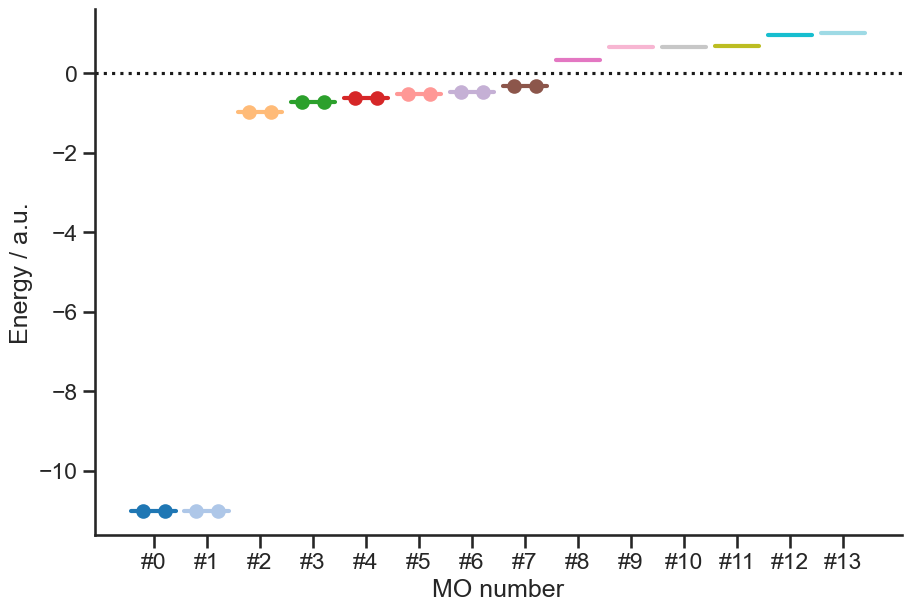

In [10]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(9, 6))
colors = matplotlib.cm.get_cmap("tab20")(np.linspace(0, 1, len(mf.mo_energy)))

pos = []
for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
    left = 3 * i
    right = 3 * i + 2.5
    length = right - left

    (line,) = ax.plot([left, right], [energy, energy], color=colors[i], lw=3)

    electron_x, electron_y = None, None
    if occ == 2:
        electron_x = [left + 0.25 * length, left + 0.75 * length]
        electron_y = [energy, energy]
    elif occ == 1:
        electron_x, electron_y = [left + 0.5], [energy]
    if electron_x and electron_y:
        ax.scatter(electron_x, electron_y, color=line.get_color())

    pos.append(left + 0.5 * length)

ax.axhline(y=0, ls=":", color="k")
ax.set_xticks(pos)
ax.set_xticklabels([f"#{i}" for i, _ in enumerate(pos)])
ax.set(xlabel="MO number", ylabel="Energy / a.u.")
sns.despine(fig=fig)

In [11]:
def get_mo(mf, mol):
    """Get molecular orbitals"""
    orbitals = {"canonical": mf.mo_coeff}

    # Get intrinsic bonding orbitals and localized intrinsic valence virtual orbitals (livvo):
    orbocc = mf.mo_coeff[:, 0 : mol.nelec[0]]
    orbvirt = mf.mo_coeff[:, mol.nelec[0] :]

    ovlpS = mol.intor_symmetric("int1e_ovlp")

    iaos = lo.iao.iao(mol, orbocc)
    iaos = lo.orth.vec_lowdin(iaos, ovlpS)
    ibos = lo.ibo.ibo(mol, orbocc, locmethod="IBO")
    orbitals["ibo"] = ibos

    livvo = lo.vvo.livvo(mol, orbocc, orbvirt)
    orbitals["livvo"] = livvo
    return orbitals

In [12]:
orbitals = get_mo(mf, mol)

 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 9.97e-10
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 8.36e-09


In [13]:
def write_all_coeffs(
    mol, coeffs, prefix="cmo", dirname=".", margin=5, offset=0
):
    """Write cube files for the given coefficients."""
    path = pathlib.Path(dirname)
    path.mkdir(parents=True, exist_ok=True)

    for i in range(coeffs.shape[1]):
        outfile = f"{prefix}_{i+offset:02d}.cube"
        outfile = path / outfile
        print(f"Writing {outfile}")
        tools.cubegen.orbital(mol, outfile, coeffs[:, i], margin=margin)

In [14]:
def find_homo_lumo(mf):
    lumo = float("inf")
    lumo_idx = None
    homo = -float("inf")
    homo_idx = None
    for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
        if occ > 0 and energy > homo:
            homo = energy
            homo_idx = i
        if occ == 0 and energy < lumo:
            lumo = energy
            lumo_idx = i

    return homo, homo_idx, lumo, lumo_idx


_, homo_idx, _, lumo_idx = find_homo_lumo(mf)
print(f"HOMO (index): {homo_idx}")

HOMO (index): 7


In [15]:
tools.cubegen.orbital(
    mol, "cmo_homo.cube", orbitals["canonical"][:, homo_idx], margin=5
)
tools.cubegen.orbital(
    mol, "cmo_lumo.cube", orbitals["canonical"][:, lumo_idx], margin=5
)
tools.cubegen.orbital(mol, "ibo_homo.cube", orbitals["ibo"][:, -1], margin=5)
tools.cubegen.orbital(
    mol, "livvo_lumo.cube", orbitals["livvo"][:, 0], margin=5
);

In [4]:
homo_voldata = open('./cmo_homo.cube', 'r').read()
lumo_voldata = open('./cmo_lumo.cube', 'r').read()

In [5]:
v = py3Dmol.view()
v.addVolumetricData(homo_voldata, "cube", {'isoval': -0.03, 'color': "red", 'opacity': 0.75})
v.addVolumetricData(homo_voldata, "cube", {'isoval': 0.03, 'color': "blue", 'opacity': 0.75})
v.addModel(Chem.MolToMolBlock(mol), 'mol')
v.setStyle({'stick':{}})
v.zoomTo()
v.show()

NameError: name 'py3Dmol' is not defined